<center>
  <h1>
    Teknofest 2023 - AI in Medicine Starter Notebook
  </h1>
</center>

<h2>1- Introduction</h2>

<p>
The root directory consist of two sub folders. These are private and TEKNOFEST_MG_EGITIM_1. We will be using TEKNOFEST_MG_EGITIM_1, it consist subfolders for each patient.
Every subfolder includes 4 mamogram results which taken from different perspectives. Dataset consist of total 3980 patient.
</p>

<h3>Importings and Macros</h3>

In [2]:
# Libraries
from pydicom.pixel_data_handlers import apply_windowing
from joblib import Parallel, delayed
from tqdm import tqdm
from io import BytesIO
from ftplib import FTP
from enum import Enum

import matplotlib.pyplot as plt
import concurrent.futures
import pandas as pd
import numpy as np
import pydicom
import cv2
import os

In [272]:
# Creditentials and ftp object
VIEWS = ['LCC.dcm', 'LMLO.dcm', 'RCC.dcm', 'RMLO.dcm']
FTP_HOST = "212.175.171.66"
FTP_USER = 'oztas18@itu.edu.tr'
FTP_PASS = '5Mn5AkST9tZnU47'

ftp = FTP(FTP_HOST, FTP_USER, FTP_PASS)
ftp.cwd('TEKNOFEST_MG_EGITIM_1')
patients = ftp.nlst() 

## Read veribilgisi excel file

# with open('../FTP/veribilgisi.xlsx', 'wb') as f:
#  ftp.retrbinary("RETR veribilgisi_11_01_23.xlsx", f.write)
patient_details = pd.read_excel('../FTP/veribilgisi.xlsx')

<h3>Functions</h3>

In [273]:

def show_images_for_patient(self, patient_id):
  """Shows every images for patients."""
  fig, axs = plt.subplots(2, 2, figsize=(16,8))
  axs = axs.flatten()
  for i, img_path in enumerate(VIEWS):
      ds = self.read_dcm_ftp(patient_id + '/' + img_path)
      axs[i].imshow(self.rescale_img_to_hu(ds), cmap="bone")

def save_as_png(self, dcm, size=512, save_folder='./', extension='.png'):
  """Saves the dcm files as png."""
  patient = dcm.split('/')[-2]
  image = dcm.split('/')[-1][:-4]

  dicom = self.read_dcm_ftp(dcm)
  
  img = dicom.pixel_array

  img = (img - img.min()) / (img.max() - img.min())

  if dicom.PhotometricInterpretation == "MONOCHROME1":
      img = 1 - img

  img = cv2.resize(img, (size, size))

  cv2.imwrite(save_folder + f"{patient}_{image}.{extension}", (img * 255).astype(np.uint8))

In [274]:
class BoundingBox(object):
    def __init__(self, top_left, bottom_right):
        self.top_left = top_left
        self.bottom_right = bottom_right

In [275]:
class Side(Enum):
    LEFT = 1
    RIGHT = 2

In [276]:
class Preprocessor(object):
    """
    Class that preprocess input dataset in dicom format for breast cancer recognition. 
    """
    def __init__(self):
        """
        Args:
            ftp: FTP Server Object
        """
        pass

    def process_images(self, n=len(patients), windowing = True, size = (512, 512), to_dtype = 'uint8', save = False, 
                 returnProcessedImgs = False, convertToOneSide = False, side = Side.LEFT):

        """ Main function that does all the processing: windowing, shuffling, resizing, saving and converting images to one side unifomrly (left or right)
        Args:
            n (int): Number of images to process
            windowing (bool): Windowing technique to be applied. Defaults to True.
            shuffle (bool): Weather images will be shuffled. Defaults to False.
            size (tuple): output image size. Defaults to (512, 512)
            to_dtype (string): Output image format. Defaults to 'uint8'.
            save (bool): Weather images will be saved. Defaults to False.
            returnProcessedImgs (bool): Weather images will be return as function result. Can be used when directly preprocessing for training in pipeline. Defaults to False.
            convertToOneSide (bool): Weather images will be converted to one side, either left or right. Defaults to False.
            side (Side): Which side (left or right) are images oriented.
        Returns:
            List: List of processed images.
        """
        retVal = []
        
        for i, patient in enumerate(patients[:n]):
            for view in VIEWS:
                path = patient + '/' + view
                img = self.get_pixels(path, windowing = windowing, to_dtype = to_dtype)
                # determine side before cropping
                img_side = self.determine_side(img)

                bbox, _ = self.get_bbox(img, 5)
                img = self.crop_image(img, bbox)
                
                if convertToOneSide:
                    # if image is not on specified side
                    if img_side != side: 
                        # Use Flip code 1 to flip horisontally
                        img = cv2.flip(img, 1)
                    
                    
                img = cv2.resize(img, size)
                if save:
                    orig_img_name = path.split(sep = '/')[-1]
                    orig_patient_name = path.split(sep = '/')[-2]
                    img_name = orig_patient_name + '_' + orig_img_name.split(sep = '.')[0] + '.png'
                    if not os.path.exists(f'../FTP/dataset/{orig_patient_name}'):
                        os.makedirs(f'../FTP/dataset/{orig_patient_name}')
                    cv2.imwrite(os.path.join(f'../FTP/dataset/{orig_patient_name}' , img_name), img)
                    
                if returnProcessedImgs:
                    retVal.append(img)
        
        return retVal
        

    def read_dcm_ftp(self, dcm):
        
        """Read dcm file from ftp server."""
        dicom_file = BytesIO()
        try:
            ftp.retrbinary(f"RETR {dcm}", dicom_file.write)
        except:
            ftp = FTP(FTP_HOST, FTP_USER, FTP_PASS)
            ftp.cwd('TEKNOFEST_MG_EGITIM_1')
            ftp.retrbinary(f"RETR {dcm}", dicom_file.write)
        dicom_file.seek(0)

        return pydicom.read_file(dicom_file, force=True)   
            
    def get_file_paths(self, imgs_path: str, csv_path: str, n: int, shuffle = False):
        """_summary_

        Args:
            imgs_path (str): path to directory contatining images
            csv_path (str): path to directory contatining csv data
            n (int): number of images to load
            shuffle (bool): Weather images will be shuffled. Defaults to False.

        Returns:
            List: list of paths to file
        """
        
        df = pd.read_csv(csv_path)
        if shuffle:
            data = np.random.permutation(df[['image_id', 'patient_id']].values)
            img_id = data[:, 0]
            patient_id = data[:, 1]
        else:
            data = df[['image_id', 'patient_id']].values
            img_id = data[:, 0]
            patient_id = data[:, 1]    
        file_names = []
        for i in range(n):
            file_names.append(f'{imgs_path}/{str(patient_id[i])}/{str(img_id[i])}.dcm')

        return file_names
    
    
    def get_pixels(self, dcm_file : str, windowing = True, to_dtype = 'uint8'):
        """  Gets image as numpy array in specified datatype from dicom format

        Args:
            dcm_file (str): Path to dcm file
            windowing (bool): Windowing technique to be applied.. Defaults to True.
            to_dtype (string): Output image format. Defaults to 'uint8'.

        Raises:
            Exception: For invalid arguments

        Returns:
            np.array: Image
        """
        valid_dtype = ['float16', 'float32','uint8']
        if to_dtype not in valid_dtype:
            raise Exception(f"{to_dtype} is not valid argument. Valid arguments are {valid_dtype}")

        scan = self.read_dcm_ftp(dcm_file)

        data = scan.pixel_array

        # apply windowing to the original image to make contrast between soft and
        # hard tissue more visible
        if windowing:
            data = apply_windowing(data, scan)

        # normalize image to 
        if scan.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        else:
            data = data - np.min(data)

        if np.max(data) != 0:
            data = data / np.max(data)

        if to_dtype == 'uint8':
            data=(data * 255).astype(dtype = to_dtype)
        else:
            data=data.astype(dtype = to_dtype)


        return data
    
    
    def get_bbox(self, img, threshold = 5):
        """
        img: input image
        threashold: should be 5, experimentally derived
        """
        if img.dtype == 'uint8':
            ret, thresh = cv2.threshold(img, threshold, 255, 0)
        else:
            img = (255*img).astype(dtype = 'uint8')
            ret, thresh = cv2.threshold(img, threshold, 255, 0)

        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = max(contours, key=cv2.contourArea)

        contour = np.squeeze(contour)
        bbox = BoundingBox(top_left = (min(contour[:, 0]), min(contour[:, 1])), bottom_right = (max(contour[:, 0]), max(contour[:, 1])))
        return bbox, img # return bbox and image in uint8 representation
    

    def determine_side(self, img, threshold = 5):
        """
        img: input image
        threshold: for binirizing image, should be 5
        Side is determined simply by finding more white side of the image.
        """

        if img.dtype == 'uint8':
            ret, thresh = cv2.threshold(img, threshold, 255, 0)
        else:
            img = (255*img).astype(dtype = 'uint8')
            ret, thresh = cv2.threshold(img, threshold, 255, 0)

        width = img.shape[1]
        # take all columns up to half image (in width), sumarize them and compare with other half
        if sum(sum(thresh[:, :width // 2])) > sum(sum(thresh[:, width // 2:])): 
            return Side.LEFT
        else:
            return Side.RIGHT
    
    
    def crop_image(self, img, bbox):
        """
        img: image to crop
        bbox: bounding box that defines new image
        """
        return img[bbox.top_left[1]:bbox.bottom_right[1], bbox.top_left[0]:bbox.bottom_right[0]]

<h2>2- Exploratory Data Analysis (EDA)</h2>

<h3>Data Preprocessing</h3>

In [277]:
prep = Preprocessor()

In [270]:
prep.process_images(n=3, windowing=True, save=True, convertToOneSide=True)

[]

In [218]:
img_windowed = prep.get_pixels(patients[0] + '/' + VIEWS[2], windowing=False)
bbox, img = prep.get_bbox(img_windowed, 5)
# convert to colored and plot bounding box
img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
# plot bounding box with green
boxed_img = cv2.rectangle(img, bbox.top_left, bbox.bottom_right, (0, 255, 0), 10)
plt.imshow(boxed_img)
plt.title('With bounding box')

TypeError: get_pixels() got an unexpected keyword argument 'windowing'

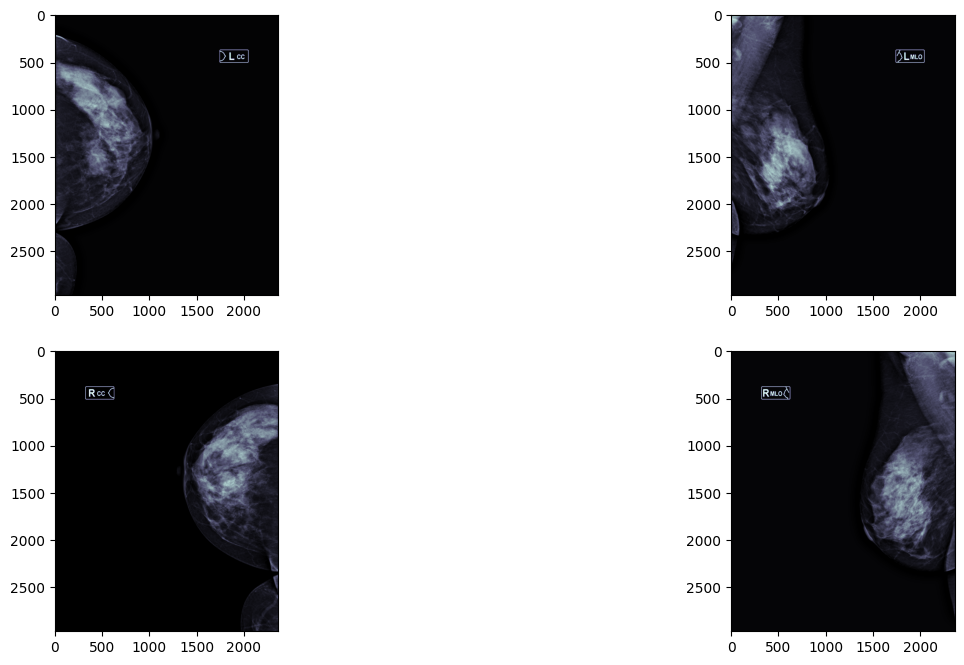

In [175]:
prep.show_images_for_patient(patients[0])

In [176]:
prep.read_dcm_ftp(f'{patients[0]}/{VIEWS[0]}')

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital Mammography X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.392.200036.9125.4.0.2551161654.939656552.935993593
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.30071.8
(0002, 0013) Implementation Version Name         SH: 'fo-dicom 4.0.7'
(0002, 0016) Source Application Entity Title     AE: 'KETEMPACS01'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', '', '', '', '', '', '', '50000']
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.822670188.1.2
(0008,

In [177]:
for dcm in [f'{patients[0]}/{VIEWS[0]}', f'{patients[1]}/{VIEWS[0]}']:
  prep.save_as_png(dcm, size=512, save_folder='../FTP/dataset/', extension='.png')

In [282]:
patient_details[(patient_details['BIRADS KATEGORİSİ'] == 'BI-RADS0')].head(100)

,HASTANO,BIRADS KATEGORİSİ,MEME KOMPOZİSYONU,KADRAN BİLGİSİ (SAĞ),KADRAN BİLGİSİ (SOL),"Birads Skoru (EK BİLGİ OLARAK VERİLMİŞTİR, YARIŞMADA İSTENMEYECEKTİR)"
0,822670188,BI-RADS0,D,NaN,"[""MERKEZ""]",Kategori 0: Ek değerlendirme tetkiki yapılmalıdır
2,822670197,BI-RADS0,D,"[""MERKEZ""]","[""MERKEZ""]",Kategori 0: Ek değerlendirme tetkiki yapılmalıdır
12,822670234,BI-RADS0,D,"[""ÜST DIŞ""]",NaN,Kategori 0: Ek değerlendirme tetkiki yapılmalıdır
14,822670237,BI-RADS0,D,NaN,"[""ÜST DIŞ""]",Kategori 0: Ek değerlendirme tetkiki yapılmalıdır
35,822670282,BI-RADS0,C,NaN,"[""ÜST DIŞ""]",Kategori 0: Ek değerlendirme tetkiki yapılmalıdır
...,...,...,...,...,...,...
1633,822689158,BI-RADS0,D,"[""ÜST DIŞ""]",NaN,Kategori 0: Ek değerlendirme tetkiki yapılmalıdır
1635,822688844,BI-RADS0,D,NaN,"[""ALT İÇ""]",Kategori 0: Ek değerlendirme tetkiki yapılmalıdır
1636,822689125,BI-RADS0,D,"[""ÜST DIŞ""]",NaN,Kategori 0: Ek değerlendirme tetkiki yapılmalıdır
1637,822688769,BI-RADS0,C,NaN,NaN,Kategori 0: Ek değerlendirme tetkiki yapılmalıdır


In [168]:
patient_details.isna().sum()

HASTANO                                                                     0
BIRADS KATEGORİSİ                                                           0
MEME KOMPOZİSYONU                                                           0
KADRAN BİLGİSİ (SAĞ)                                                     2703
KADRAN BİLGİSİ (SOL)                                                     2646
Birads Skoru (EK BİLGİ OLARAK VERİLMİŞTİR, YARIŞMADA İSTENMEYECEKTİR)       0
dtype: int64

In [178]:
patient_details.nunique()

HASTANO                                                                  3979
BIRADS KATEGORİSİ                                                           3
MEME KOMPOZİSYONU                                                           4
KADRAN BİLGİSİ (SAĞ)                                                       49
KADRAN BİLGİSİ (SOL)                                                       50
Birads Skoru (EK BİLGİ OLARAK VERİLMİŞTİR, YARIŞMADA İSTENMEYECEKTİR)       5
dtype: int64